In [1]:
# 导入必要的库
import os
import torch
from torch import nn
from torchvision.models import vgg16
from collections import namedtuple
import numpy as np
import torchvision as tv
from torch.utils import data
import tqdm
from torch.nn import functional as F
import matplotlib.pyplot as plt

In [2]:
# 加载VGG-16神经网络
class Vgg16(nn.Module):
    def __init__(self):
        super(Vgg16, self).__init__()
        features = list(vgg16(pretrained=True).features)[:23]
        self.features = nn.ModuleList(features).eval()

    def forward(self, x):
        results = []
        # feature的第3，8，15，22层分别是：relu1_2，relu2_2，relu3_3，relu4_3
        for ii, model in enumerate(self.features):
            x = model(x)
            if ii in {3, 8, 15, 22}:
                results.append(x)

        vgg_outputs = namedtuple("VggOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3'])
        return vgg_outputs(*results)

In [3]:
# 卷积块
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = int(np.floor(kernel_size / 2))
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out

In [4]:
# 上采样
class UpsampleConvLayer(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        reflection_padding = int(np.floor(kernel_size / 2))
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = torch.nn.functional.interpolate(x_in, scale_factor=self.upsample)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out

In [5]:
# 残差块
class ResidualBlock(nn.Module):

    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in1 = nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in2 = nn.InstanceNorm2d(channels, affine=True)
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        out = out + residual
        return out

In [6]:
# U-Net
class TransformerNet(nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()

        # 下采样
        self.initial_layers = nn.Sequential(
            ConvLayer(3, 32, kernel_size=9, stride=1),
            nn.InstanceNorm2d(32, affine=True),
            nn.ReLU(True),
            ConvLayer(32, 64, kernel_size=3, stride=2),
            nn.InstanceNorm2d(64, affine=True),
            nn.ReLU(True),
            ConvLayer(64, 128, kernel_size=3, stride=2),
            nn.InstanceNorm2d(128, affine=True),
            nn.ReLU(True),
        )

        # 残差层
        self.res_layers = nn.Sequential(
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128)
        )

        # 上采样
        self.upsample_layers = nn.Sequential(
            UpsampleConvLayer(128, 64, kernel_size=3, stride=1, upsample=2),
            nn.InstanceNorm2d(64, affine=True),
            nn.ReLU(True),
            UpsampleConvLayer(64, 32, kernel_size=3, stride=1, upsample=2),
            nn.InstanceNorm2d(32, affine=True),
            nn.ReLU(True),
            ConvLayer(32, 3, kernel_size=9, stride=1)
        )

    # 正向传播
    def forward(self, x):
        x = self.initial_layers(x)
        x = self.res_layers(x)
        x = self.upsample_layers(x)
        return x

In [7]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# 计算gram矩阵
def gram_matrix(y):
    """
    Input shape: b,c,h,w
    Output shape: b,c,c
    """
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram

# 加载风格图片
def get_style_data(path):
    """
    load style image，
    Return： tensor shape 1*c*h*w, normalized
    """
    style_transform = tv.transforms.Compose([
        tv.transforms.ToTensor(),
        tv.transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ])

    style_image = tv.datasets.folder.default_loader(path)
    style_tensor = style_transform(style_image)
    return style_tensor.unsqueeze(0)

In [8]:
# 标准化图片batch
def normalize_batch(batch):
    """
    Input: b,ch,h,w  0~255
    Output: b,ch,h,w  -2~2
    """
    mean = batch.data.new(IMAGENET_MEAN).view(1, -1, 1, 1)
    std = batch.data.new(IMAGENET_STD).view(1, -1, 1, 1)
    mean = (mean.expand_as(batch.data))
    std = (std.expand_as(batch.data))
    return (batch / 255.0 - mean) / std

class Config(object):
    # General Args
    # use_gpu = True
    # model_path = None  # pretrain model path (for resume training or test)

    # Train Args
    image_size = 256  # image crop_size for training
    batch_size = 8
    data_root = '/kaggle/input/mini-coco2014-dataset-for-image-captioning'  # dataset root：$data_root/coco/a.jpg
    num_workers = 4  # dataloader num of workers

    lr = 1e-3
    epoches = 2  # total epoch to train
    content_weight = 1e5  # weight of content_loss
    style_weight = 1e10  # weight of style_loss

    style_path = '/kaggle/input/monet-style/style.jpg'  # style image path
    # env = 'neural-style'  # visdom env
    plot_every = 100  # visualize in visdom for every 10 batch

    # debug_file = '/tmp/debugnn'  # touch $debug_fie to interrupt and enter ipdb

    # Test Args
    content_path = '/kaggle/input/mini-coco2014-dataset-for-image-captioning/Images/COCO_train2014_000000000009.jpg'  # input file to do style transfer [for test]
    result_path = '/kaggle/working/'  # style transfer result [for test]
    
    ngpu = 2

In [9]:
def show(num):
    pass

In [10]:
def test(path1, path2):
    content_image = tv.datasets.folder.default_loader(path1)
    content_transform = tv.transforms.Compose([
        tv.transforms.ToTensor(),
        tv.transforms.Lambda(lambda x: x.mul(255))
    ])
    content_image = content_transform(content_image)
    content_image = content_image.unsqueeze(0).to(device).detach()
    # style transfer and save output
    transformer.eval()
    with torch.no_grad():
        output = transformer(content_image)
        output_data = output.cpu().data[0]
        tv.utils.save_image(((output_data / 255)).clamp(min=0, max=1), path2)
    transformer.train()

In [11]:
opt = Config()

# 设置训练设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data loading
transfroms = tv.transforms.Compose([
    tv.transforms.Resize(opt.image_size),
    tv.transforms.CenterCrop(opt.image_size),
    tv.transforms.ToTensor(),
    tv.transforms.Lambda(lambda x: x * 255)
])

In [12]:
dataset = tv.datasets.ImageFolder(opt.data_root, transfroms)
dataloader = data.DataLoader(dataset, opt.batch_size)

In [13]:
vgg = Vgg16().eval()
vgg.to(device)
for param in vgg.parameters():
    param.requires_grad = False

style = get_style_data(opt.style_path)       # 1*c*h*w
# print(style.size())
style = style.to(device)

transformer = TransformerNet()
transformer.to(device)

if torch.cuda.is_available() and opt.ngpu > 1:         # 当 torch.cuda.is_available() 为真且 ngpu > 1 时              
    transformer = nn.DataParallel(transformer, device_ids=list(range(opt.ngpu)))
    
# Optimizer
optimizer = torch.optim.Adam(transformer.parameters(), opt.lr)

# gram matrix for style image
with torch.no_grad():
    features_style = vgg(style)
    gram_style = [gram_matrix(y) for y in features_style]

content_losses = []
style_losses = []

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 159MB/s]


2348it [15:27,  2.53it/s]
2348it [15:33,  2.52it/s]


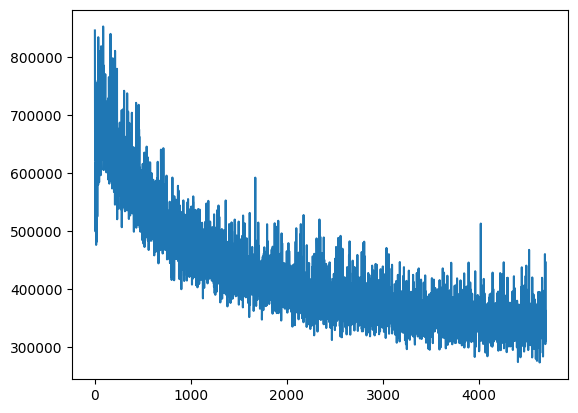

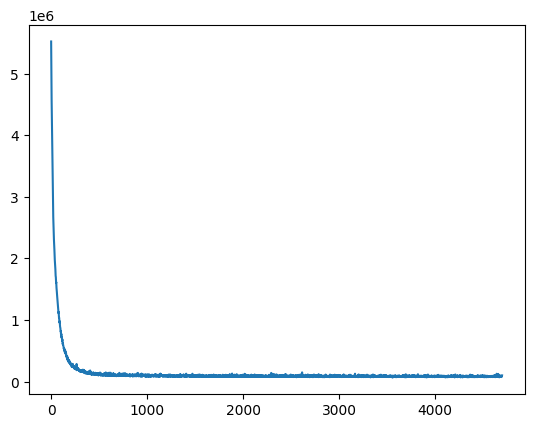

In [14]:
for epoch in range(opt.epoches):
    for ii, (x, _) in tqdm.tqdm(enumerate(dataloader)):
        # Train
        optimizer.zero_grad()
        x = x.to(device)
        y = transformer(x)
        y = normalize_batch(y)
        x = normalize_batch(x)
        features_y = vgg(y)
        features_x = vgg(x)

        # content loss
        content_loss = opt.content_weight * F.mse_loss(features_y.relu2_2, features_x.relu2_2)

        # style loss
        style_loss = 0.
        for ft_y, gm_s in zip(features_y, gram_style):
            gram_y = gram_matrix(ft_y)
            style_loss += F.mse_loss(gram_y, gm_s.expand_as(gram_y))

        style_loss *= opt.style_weight

        content_losses.append(content_loss.item())
        style_losses.append(style_loss.item())

        total_loss = content_loss + style_loss
        total_loss.backward()
        optimizer.step()

        if (ii + 1) % opt.plot_every == 0:
            show((ii + 1)/opt.plot_every)

torch.save(transformer.state_dict(),
           '/kaggle/working/model_best.pth')

plt.figure(1)
plt.plot(content_losses)
plt.figure(2)
plt.plot(style_losses)
plt.show()

# transformer.load_state_dict(torch.load('/kaggle/working/model_best.pth'))
# A = '/kaggle/working/test.jpg'
# B = '/kaggle/working/output.jpg'
# test(A, B)